<a href="https://colab.research.google.com/github/wehs7661/deep_learning_projects/blob/master/covid_regression/DNN_test_positive/covid_regression_test_positive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A deep neural network for predicting the COVID-19 positive rate**

This notebook is adapted from the homework notebook ([Homework 1](https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb), written by Heng-Jui Chang @ NTUEE) of the 2021 Machine Learning class taught by Dr. Hung-Yi Lee @ NTUEE. The explanation of the assignment can be found in the following links:
- Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
- Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
- Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529

The overall goal of this notebook is to guide you through the process of building, training, and assessing a neural network for solving a regression problem - predicting the COVID-19 positive rate, and provide hands-on experience in improving the model. In the original assignment, the predictions made by the model were required to be uploaded to [Kaggle](https://www.kaggle.com/competitions/ml2021spring-hw1). In addition to the assignment submission, which grants 4 points, each of the remaining 6 points can be gained by passing the baselines tabulated. Notably, a lower score corresponds to a lower test loss, which is better. 

|                 | Public leaderboard | Private leaderboard |
|-----------------|--------------------|---------------------|
| Simple baseline | 2.03004            | 2.04826             |
| Medium baseline | 1.28359            | 1.36937             |
| Strong baseline | 0.88017            | 0.89266             |

In the instructions of the original assignment, the following tips were given to pass different baselines:
- To pass the simple baseline, one can just run the sample codes provided in Sections 1 to 5.
- To pass the medium baseline, one needs to perform feature selections, specifically only using the one-hot vector of states (40 features) and the positive rates of Days 1 and 2 as the features (i.e. 42 features in total) instead of using all the 93 possible features. 
- To pass the strong baseline, one needs to apply L1 or L2 regularization to the model. (However, as we found later, simply applying L1 or L2 regularization might not be sufficient).

Also, playing around with the hyper-parameters or modifying the architecture of the model could help improve the performance. 

In this notebook, we at least pass the single and medium baselines. Passing the strong baselines would require more techniques like feature selection or regularization, which we will leave to [the second notebook](https://github.com/wehs7661/deep_learning_projects/blob/master/covid_regression/DNN_test_positive/feature_selection.ipynb) of this topic. 

## **Section 1. Understand our datasets**
Here, we first first download the training set and the test set, which were extracted and adapted from the [daily surveys conducted by the Delphi Group @ CMU](https://delphi.cmu.edu/covidcast/). If the Google drive links are not working, you can download the data from [Kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data).



In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 116MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 24.9MB/s]


In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None) # to show all coumns below
df = pd.read_csv('covid.train.csv'); df

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,WI,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.814610,0.771356,25.648907,21.242063,84.644672,13.462475,36.519841,63.139094,23.835119,44.726055,16.946929,1.716262,15.494193,12.043275,17.000647,53.439316,43.279629,19.586492,0.838995,0.807767,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.838995,0.807767,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.897802,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116842,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656,0.947

As shown above, the training set has 95 columns, which include:
- 1 column of the IDs
- 40 columns showing the states encoded to one-hot vectors
- 18 columns of Day 1 features
- 18 columns of Day 2 features
- 18 columns of Day 3 features

More specifically, the 18 features for each day include the follows:
- 4 columns of COVID-like illness, including
  - `ili`: Percentage of people having influenza-like illness
  - `cli`: Percentage of people having COVID-like illness
  - `hh_cmnty_cli`: Percentage of people reporting illness in their local community, including their household
  - `noww_cmnty_cli`: Percentage of people reporting illness in their local community, not including their household 
- 8 columns of behavior indicators, including `wearing_mask`, `travel_outside_state`, `work_outside_home`, `shop`, `restaurant`, `spent_time`, `large_event`, and `public_transit`. Most names of indicators are self-explanatory, except for `spent_time`, which is the percentage of respondents who spent time indoors with someone who isn't currently staying with them in the past 24 hours. 
- 5 columns of mental health indicators, including `anxious`, `depressed`, `felt_isolated`, `worried_become_ill`, and `worried_finances`.
- 1 column showing the percentage of people who tested positive

All indicators above are expressed in percentages. For more details about how the data was collected and how the indicators were designed, please visit [this site](https://cmu-delphi.github.io/delphi-epidata/api/covidcast-signals/fb-survey.html).



As can be examined, there are 2700 samples (2700 rows) in the training dataset and 893 samples in the test set. With these datasets, our goal is to build a deep neural network to **predict the COVID-19 positive rate of Day 3 (in percentage)**, first using any of the 93 indicators as features to pass the simple baselines. (Note that in the test set, there are only 94 columns, with the missing one being the test positive rate of Day 3 that we are going to predict. The test loss will be calculated on Kaggle once the predictions (the file `pred.csv` that we will generate below) are uploaded to Kaggle.)

## **Section 2. Setting things up**

First, we import packages to be used in our notebook and set the random seed:

In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def set_seed(seed=42069):
    # set a random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

For convenience, here are some handy utility functions.

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='Training loss')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='Validation loss')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Section 3. Preparing the datasets**

Below we define the class `COVID19Dataset`, which is for preparing a training set, a validation set, or a test set. Specifically, `COVID19Dataset` 
- Reads `.csv` files
- Extracts features
- Splits `covid.train.csv` into the training set and validation set when needed
- Normalizes features

In `COVID19Dataset`, 1 out of every 10 points in the training set is used for validation. Note that compared to the original sample code of `COVID19Dataset` written by Chang, the following changes have been made:
- I changed the input arguments to the class to allow higher flexibility in considering arbitrary numbers of features. 
- The original code was considering features with indices from 0 to 92, which is incorrect since the ID/row index should not be a feature. I've fixed this error.
- Some docstrings have been added.

In [5]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self, path, mode='train', feats=list(range(93))):
        """
        Prepares a dataset as specified.

        Parameters
        ----------
        path : str
            The path of the training dataset or the test set. 
        mode : str
            How the dataset should be prepared. Available options include "train", 
            "dev", and "test".
        feats: 
            The list of feature indices to consider.
        """
        self.mode = mode

        # Step 1: Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float) # note that the ID has been left out
        
        # Step 2: Prepare the dataset
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Step 3: Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print(f'Finished reading the {mode} set of COVID19 Dataset ({len(self.data)} samples found, each dim = {self.dim})')

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

Then, we define `prep_dataloader`, which can be used to construct dataloaders for loading data. (Specifically, in `prep_dataloader`, `DataLoader` loads data from a given `Dataset` into batches.)

In [6]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, feats=list(range(93))):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, feats=feats)  # Construct dataset
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode == 'train'), drop_last=False, num_workers=n_jobs, pin_memory=True)
    return dataloader

# **Section 4. Define classes/functions to build, train, and test neural networks**

Now, we build the class `NeuralNet` that inherits `nn.Module` for data regression. This DNN consists of 2 fully-connected layers with ReLU activation. This module also includes a function `cal_loss` for calculating the MSE loss. 

In [7]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

Then, we define functions for training, validating, and testing the neural network.

In [8]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print(f'Saving model (epoch = {epoch + 1}, validation loss = {min_mse:.4f}')
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [9]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Section 5. Build, train, and assess a neural network**

With the classes and functions defined above, let's build and train a neural network to pass the simple baselines! To do this, we define a dictionary `config` that contains hyper-parameters for training, and the path to save the model.

In [11]:
device = get_device()                    # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)     # The trained model will be saved to ./models/
feats= list(range(93))

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

Below we set up data loaders for loading the training set, validation set and the test set. Then we construct our first neural network.

In [12]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], feats=feats)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], feats=feats)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], feats=feats)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [13]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

Now let's start training the model!

In [14]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch = 1, validation loss = 78.8524
Saving model (epoch = 2, validation loss = 37.6170
Saving model (epoch = 3, validation loss = 26.1203
Saving model (epoch = 4, validation loss = 16.1862
Saving model (epoch = 5, validation loss = 9.7153
Saving model (epoch = 6, validation loss = 6.3701
Saving model (epoch = 7, validation loss = 5.1802
Saving model (epoch = 8, validation loss = 4.4255
Saving model (epoch = 9, validation loss = 3.8009
Saving model (epoch = 10, validation loss = 3.3691
Saving model (epoch = 11, validation loss = 3.0943
Saving model (epoch = 12, validation loss = 2.8176
Saving model (epoch = 13, validation loss = 2.6274
Saving model (epoch = 14, validation loss = 2.4542
Saving model (epoch = 15, validation loss = 2.3012
Saving model (epoch = 16, validation loss = 2.1766
Saving model (epoch = 17, validation loss = 2.0641
Saving model (epoch = 18, validation loss = 1.9399
Saving model (epoch = 19, validation loss = 1.8978
Saving model (epoch = 20, validation

As shown above, the model was trained for 1444 epochs and the minimum loss validation loss was 0.7582. The training loss and validation loss as functions of the number of training steps can be plotted as follows.

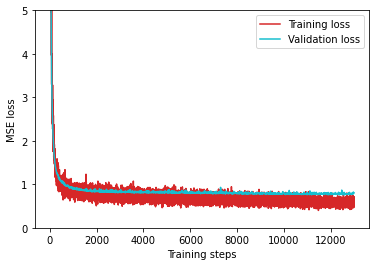

In [15]:
plot_learning_curve(model_loss_record)

Another way to assess the neural network is to compare its predictions with the labels in the validation set.

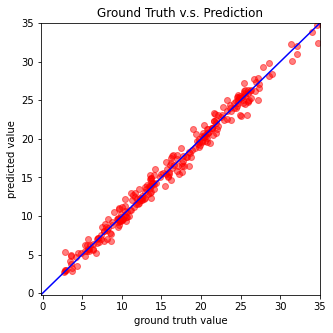

In [16]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

Note that we don't have the labels in the test set to calculate the test loss, but we can save `pred_1.csv` below and upload it to Kaggle to estimate the test loss, which is reflected by the score. 

In [17]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)    # predict COVID-19 cases with your model
save_pred(preds, 'pred_1.csv')         # save prediction file to pred_1.csv

Saving results to pred_1.csv


As shown above, a CSV file containing the predictions, `pred.csv` will be saved. At this point, the predictions will gain a score of 1.35265 if they are uploaded to Kaggle, which passes both the simple baselines but not the medium baselines. 

# **Section 6. Feature selection**

To pass the medium baselines, we should consider only 42 features (one-hot vector and the positive rates of Days 1 (index and 2) instead of 93. 

In [18]:
device = get_device()                    # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)     # The trained model will be saved to ./models/
feats= list(range(40)) +  [57, 75]

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], feats=feats)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], feats=feats)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], feats=feats)

model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 42)
Saving model (epoch = 1, validation loss = 261.9146
Saving model (epoch = 2, validation loss = 28.6903
Saving model (epoch = 3, validation loss = 25.6512
Saving model (epoch = 4, validation loss = 19.4630
Saving model (epoch = 5, validation loss = 3.6502
Saving model (epoch = 6, validation loss = 2.1722
Saving model (epoch = 8, validation loss = 2.0815
Saving model (epoch = 9, validation loss = 1.6197
Saving model (epoch = 10, validation loss = 1.5207
Saving model (epoch = 11, validation loss = 1.5042
Saving model (epoch = 12, validation loss = 1.4746
Saving model (epoch = 13, validation loss = 1.4315
Saving model (epoch = 14, validation loss = 1.4003
Saving model (epoch = 15, validation loss = 1.3806
Saving model (epoch = 16, validation

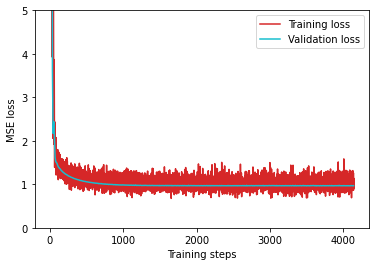

In [19]:
plot_learning_curve(model_loss_record)

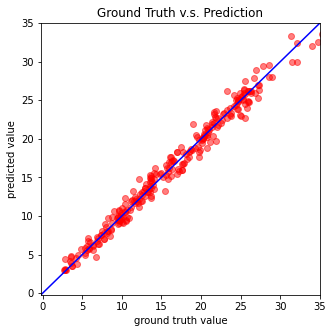

In [20]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [21]:
preds = test(tt_set, model, device)    # predict COVID-19 cases with your model
save_pred(preds, 'pred_2.csv')         # save prediction file to pred_2.csv

model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

Saving results to pred_2.csv


As examined on Kaggle, the predictions generated by the model considering only 42 features gained a score of 1.05789, which is lower than the score we originally got and passed both the medium baselines. Note that although the first model had a smaller minimum validation loss, it was not able to accurately predict the labels in the test set and had a higher test loss. Therefore, there must be an issue of overfitting in the first model.

So this is the end of the notebook! To see how the strong baselines can be passed, you're welcome to visit [the other notebook](https://github.com/wehs7661/deep_learning_projects/blob/master/covid_regression/DNN_test_positive/feature_selection.ipynb) I wrote for this assignment. Thank you for reading this far!